### PyTorch Classical XY-Model

The equations:


$F[\vec \phi]=\int d^2x[(\nabla \vec \phi)^2+V_0(\vec \phi ^2 - 1)^2]$

$\partial _ t \vec \phi = -\Gamma \delta F / \delta \vec \phi$

$ \langle \vec \phi (x,0)\cdot \vec \phi (x',0) \rangle = \Delta \delta (x-x')$


The actual equation that I end up solving:

$\frac {d \vec \phi}{dt} = - \Gamma ( V_0 2 \vec \phi (\vec \phi ^2 - 1) - 2 \nabla ^2 \vec \phi)$

I do this for x and y (two seperate equations) with backwards euler 5-point gradiant stencil as numerical scheme.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import imageio.v2 as imageio
from IPython.display import Image, display, HTML
import time
from scipy.optimize import curve_fit
from natsort import natsorted
import torch
import torch.nn.functional as F

In [2]:
# Constants

# The interesting physics parameter :)
V_0 = 1
# Kinetic coefficient (timescale) should be less than or equal to 1 
Gamma = 0.5
# Determines the order of the initial state (not used)
Delta = 1
# Scalar
s = 1
# Size of lattice
N = 256
M = N
# Time step
dt = 0.1
# Amount of timesteps I want the simulation to run in units: number divided by size of dt
T = 1000
# Seed to reproduce the randomization
np.random.seed(69420)
torch.manual_seed(0)
# Determines interval between images saved for plotting
step_interval = 10

In [3]:
# Just some testing to make sure I'm using the GPU
torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1060 3GB'

In [4]:
# Makes sure the code uses GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print("No GPU available, using CPU.")
    device = torch.device("cpu")

In [5]:
# Function that initializes a field
def create_vector_field(N, M):
    vector_field = torch.empty((N, M, 2), device=device)
    angle = torch.rand(N, M, device=device) * 2 * np.pi
    vector_field[..., 0] = s * torch.cos(angle)
    vector_field[..., 1] = s * torch.sin(angle)
    return vector_field

vector_matrix = create_vector_field(N, M)

In [6]:
# Function that calculates the angles of a field
def angle_from_field(vector_field):
    angle_field = torch.atan2(vector_field[..., 1] / s, vector_field[..., 0] / s)
    return angle_field

# Function that calculates the scalars of a field
def scalar_from_field(vector_field):
    scalar_field = torch.sqrt(vector_field[..., 0] ** 2 + vector_field[..., 1] ** 2)
    return scalar_field

In [7]:
# Function that defines the derivative/numerical scheme
def vector_field_derivative(vector_field):
    up = torch.roll(vector_field, shifts=-1, dims=0)
    down = torch.roll(vector_field, shifts=1, dims=0)
    left = torch.roll(vector_field, shifts=-1, dims=1)
    right = torch.roll(vector_field, shifts=1, dims=1)

    non_linear_term = V_0 * 2 * vector_field * (torch.sum(vector_field ** 2, dim=-1, keepdim=True) - 1)
    laplacian_term = (up + down + left + right - 4 * vector_field)

    vector_field_derived = -Gamma * (non_linear_term - 2 * laplacian_term)
    return vector_field_derived

In [8]:
# Computes next time step
def compute_next_step(vector_field, dt):
    derivative = vector_field_derivative(vector_field)
    vector_field_next_step = vector_field + dt * derivative
    return vector_field_next_step

# Gets angles and scalars from time step
def compute_fields(vector_field):
    angle_field = angle_from_field(vector_field)
    scalar_field = scalar_from_field(vector_field)
    return vector_field, angle_field, scalar_field

In [9]:
# Defines a peak detection function that works for PyTorch
def detect_peaks_torch(scalar_field, min_distance=3, threshold_rel=0.5):
    # Reshape to prevent broadcasting errors
    scalar_field = scalar_field.unsqueeze(0).unsqueeze(0)
    # Defines a field where each position contains the maximum value found in the corresponding neighbourhood of the input field
    pooled_field = F.max_pool2d(scalar_field, kernel_size=min_distance*2+1, stride=1, padding=min_distance)
    # Checks if a points is isolated from other peaks and if it's a peak itself then appends it
    mask = (scalar_field == pooled_field) & (scalar_field > threshold_rel)
    coordinates = torch.nonzero(mask.squeeze())
    
    return coordinates

In [10]:
def count_defects(scalar_field):
    coordinates = detect_peaks_torch(-scalar_field + 1, min_distance=3, threshold_rel=0.5)
    num_defects = len(coordinates)
    
    return num_defects

In [11]:
# Runs the simulation in time
# Comment out the part that saves scalars and angles if they aren't used
def time_derivative(vector_field, dt, T):
    os.makedirs("angle_field_iterations", exist_ok=True)
    os.makedirs("scalar_field_iterations", exist_ok=True)
    defect_counts = []

    t = torch.arange(0, T, dt, device=device)

    for i in range(len(t)):
        vector_field = compute_next_step(vector_field, dt)
        vector_field_iteration, angle_field, scalar_field = compute_fields(vector_field)

        if i % step_interval == 0:
            defect_count = count_defects(scalar_field.cpu())
            defect_counts.append(defect_count)
            torch.save(angle_field.cpu(), f"angle_field_iterations/angle_field_{i}.pt")
            torch.save(scalar_field.cpu(), f"scalar_field_iterations/scalar_field_{i}.pt")

    torch.save(defect_counts, "defect_counts.pt")

    return ["angle_field_iterations", "scalar_field_iterations"]

t0 = time.time()
vector_matrix_simulation = time_derivative(vector_matrix, dt, T)
t1 = time.time()
total_time = t1 - t0
print(total_time)

12.722109317779541


### Code that saves the simulation as images and GIFs to display

In [12]:
# Defines the diretories where our images end up
output_dirs = ['angle_field_images', 'scalar_field_images']
for dir in output_dirs:
    os.makedirs(dir, exist_ok=True)

# Gets lists of files in the directories
angle_files = natsorted(os.listdir("angle_field_iterations"))
scalar_files = natsorted(os.listdir("scalar_field_iterations"))

# Iterates over the files and save plots
for i in range(0, len(angle_files), step_interval):
    angle_field = torch.load(os.path.join("angle_field_iterations", angle_files[i]), weights_only=True)
    scalar_field = torch.load(os.path.join("scalar_field_iterations", scalar_files[i]), weights_only=True)

    # Saves the angle field image
    plt.figure(figsize=(5, 5))
    plt.imshow(angle_field, cmap='hsv', interpolation='none', origin='lower', vmin=-np.pi, vmax=np.pi)
    plt.colorbar()
    plt.title(f'Angles for time step {i}')
    plt.savefig(f'angle_field_images/angle_field_{i:03d}.png')
    plt.close()

    # Saves the scalar field image
    plt.figure(figsize=(5, 5))
    plt.imshow(scalar_field, cmap='inferno', interpolation='none', origin='lower', vmin=0, vmax=1)
    plt.colorbar()
    plt.title(f'Scalars for time step {i}')
    plt.savefig(f'scalar_field_images/scalar_field_{i:03d}.png')
    plt.close()

In [13]:
# Function to create GIF from images
def create_gif(image_folder, gif_filename, duration=0.1):
    images = []
    image_files = natsorted(os.listdir(image_folder))

    for image_file in image_files:
        filename = os.path.join(image_folder, image_file)
        images.append(imageio.imread(filename))
        
    imageio.mimsave(gif_filename, images, duration=duration)

# Create GIFs
create_gif('angle_field_images', 'angle_field_animation.gif')
create_gif('scalar_field_images', 'scalar_field_animation.gif')

In [14]:
# Display GIFs side by side
display(HTML("""
<div style="display: flex; justify-content: flex-start; align-items: center;">
    <img src="angle_field_animation.gif" alt="Angle Field Animation" style="margin: 0; padding: 0; width: 49%;">
    <img src="scalar_field_animation.gif" alt="Scalar Field Animation" style="margin: 0; padding: 0; width: 49%;">
</div>
"""))

In [15]:
# # Plots specific time steps
# time_steps = [50, 100, 150]

# fig, axes = plt.subplots(3, 2, figsize=(6, 8))

# for i, step in enumerate(time_steps):
#     angle_field = torch.load(os.path.join('angle_field_iterations', angle_files[step]), weights_only=True)
#     scalar_field = torch.load(os.path.join('scalar_field_iterations', scalar_files[step]), weights_only=True)

#     ax = axes[i, 0]
#     im = ax.imshow(angle_field, cmap='hsv', interpolation='none', origin='lower', vmin=-np.pi, vmax=np.pi)
#     ax.set_title(f'Angles for time step {step}', fontsize=10)
#     fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
#     ax.tick_params(axis='both', which='major', labelsize=8)

#     ax = axes[i, 1]
#     im = ax.imshow(scalar_field, cmap='inferno', interpolation='none', origin='lower', vmin=0, vmax=1)
#     ax.set_title(f'Scalars for time step {step}', fontsize=10)
#     fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
#     ax.tick_params(axis='both', which='major', labelsize=8)

# plt.tight_layout()
# plt.show()

### Data gathered by running the code with different constants followed by data analysis

In [17]:
current_defect_counts = torch.load('defect_counts.pt', weights_only=True)

#torch.save(current_defect_counts, 'defect_counts_01.pt')

#print(current_defect_counts)

# For dt=0.0001, T=10, Gamma=0.5, N=256, step_size=100
# Specifically the defect_counts_01 is currently for dt=0.001. Everything else I will try to run for 0.0001 and if that works I will rerun defect_counts_01. Maybe go for T=10000 instead?
V_0_values = torch.Tensor([0.1, 1/3, 1, 10/3, 10, 100/3, 100])


defect_counts_01 = torch.load('defect_counts_01.pt', weights_only=True)
# defect_counts_03 = torch.load('defect_counts_03.pt', weights_only=True)
# defect_counts_1 = torch.load('defect_counts_1.pt', weights_only=True)
# defect_counts_3 = torch.load('defect_counts_3.pt', weights_only=True)
# defect_counts_10 = torch.load('defect_counts_10.pt', weights_only=True)
# defect_counts_33 = torch.load('defect_counts_33.pt', weights_only=True)
# defect_counts_100 = torch.load('defect_counts_100.pt', weights_only=True)


In [18]:
#print(current_defect_counts)
#defect_counts_01 = current_defect_counts

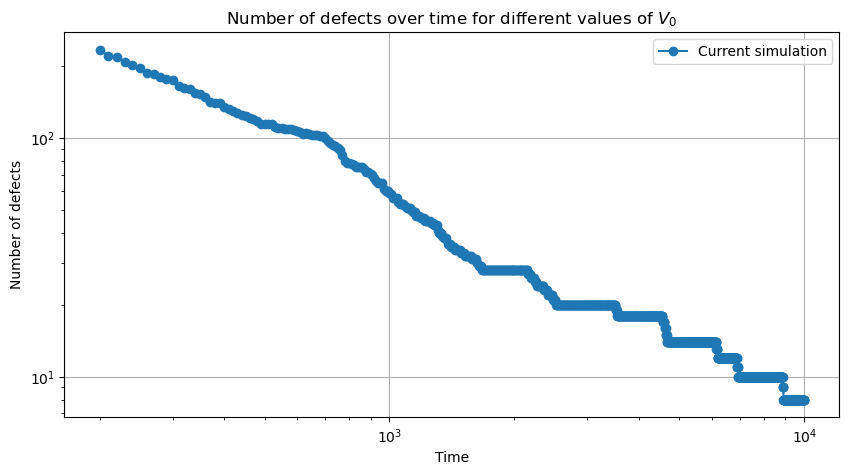

In [19]:
# Define the number of points to remove
points_to_remove = 20

# Remove the first 300 points from defect_counts and adjust the time steps accordingly
filtered_defect_counts = current_defect_counts[points_to_remove:]
filtered_defect_counts_01 = defect_counts_01[points_to_remove:]
# filtered_defect_counts_03 = defect_counts_03[points_to_remove:]
# filtered_defect_counts_1 = defect_counts_1[points_to_remove:]
# filtered_defect_counts_3 = defect_counts_3[points_to_remove:]
# filtered_defect_counts_11 = defect_counts_11[points_to_remove:]

filtered_time_steps = np.arange(points_to_remove * step_interval, len(current_defect_counts) * step_interval, step_interval)
filtered_time = filtered_time_steps * dt

# Plot the number of defects over time
plt.figure(figsize=(10, 5))
plt.plot(filtered_time_steps, filtered_defect_counts, marker='o', label='Current simulation')
#plt.plot(filtered_time, filtered_defect_counts_01, marker='o', label='V_0=0.1')
# plt.plot(filtered_time, filtered_defect_counts_03, marker='o', label='V_0=1/3')
# plt.plot(filtered_time, filtered_defect_counts_1, marker='o', label='V_0=1')
# plt.plot(filtered_time, filtered_defect_counts_3, marker='o', label='V_0=10/3')


plt.yscale('log')
plt.xscale('log')
plt.xlabel('Time')
plt.ylabel('Number of defects')
plt.title('Number of defects over time for different values of $V_0$')
plt.grid(True)
plt.legend()
plt.show()